# CLIP-DINOiser visualization demo 🖼️

In [28]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np
from operator import itemgetter 
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)


hydra.initialize()

In [30]:
def visualize_per_image(file_path, support_images, palette, model):
    assert os.path.isfile(file_path), f"No such file: {file_path}"

    # Carica e processa l'immagine principale
    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    h, w = img_tens.shape[-2:]

    # Carica e processa le immagini di supporto
    support_tensors = []
    for support_path in support_images:
        assert os.path.isfile(support_path), f"No such file: {support_path}"
        support_img = Image.open(support_path).convert('RGB')
        support_tensors.append(T.PILToTensor()(support_img).unsqueeze(0).to(device) / 255.)

    # Imposta le immagini di supporto nel modello
    model.set_support_images(support_tensors)  # Supponendo che il modello supporti l'input delle immagini di supporto

    # Esegue l'inferenza
    output = model(img_tens).cpu()
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    output = output[0].argmax(dim=0)
    mask = mask2rgb(output, palette)

    # Visualizza l'output della segmentazione
    fig = plt.figure(figsize=(3, 1))
    classes = np.unique(output).tolist()
    plt.imshow(np.array(itemgetter(*classes)(palette)).reshape(1, -1, 3))
    plt.xticks(np.arange(len(classes)), [os.path.basename(path) for path in itemgetter(*classes)(support_images)], rotation=45)
    plt.yticks([])

    return mask, fig, img

### Load and configure a model

In [36]:
check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates=False # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()

def set_support_images(model, support_images_paths):
    support_images = []
    transform = T.Compose([
        T.Resize((224, 224)),  # Assicurati che le immagini siano della dimensione corretta
        T.ToTensor()
    ])

    for img_path in support_images_paths:
        assert os.path.isfile(img_path), f"File non trovato: {img_path}"
        img = Image.open(img_path).convert('RGB')  # Apri l'immagine
        img_tensor = transform(img).unsqueeze(0)  # Trasforma in tensore e aggiungi una dimensione batch
        support_images.append(img_tensor)

    # Concatena le immagini di supporto lungo la dimensione batch
    if support_images:  # Verifica se ci sono immagini da concatenare
        support_images = torch.cat(support_images).to(next(model.parameters()).device)  # Usa il dispositivo del modello

        # Imposta le immagini di supporto nel modello
        model.clip_backbone.set_support_images(support_images)
    else:
        print("Nessuna immagine di supporto trovata.")

### Example with 'background' class

In [37]:
# Definisci il percorso del file immagine
file = 'assets/vintage_bike.jpeg'

# Imposta la palette e i nomi delle classi per visualizzare il risultato
PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]
SUPPORT_IMAGES = ['assets/bike.jpg', 'assets/leather_bag.jpeg']

# Aggiorna il vocabolario del modello per l'uso di immagini di supporto
model.clip_backbone.decode_head.update_vocab(SUPPORT_IMAGES)  # Passa il tuo elenco di immagini di supporto qui
model.to(device)

# Imposta l'applicazione di 'FOUND' a True per rilevare il background
model.apply_found = False

# Carica e imposta le immagini di supporto nel modello
set_support_images(model, SUPPORT_IMAGES)  # Passa le immagini di supporto al modello

# Esegui la segmentazione
mask, ticks, img = visualize_per_image(file, SUPPORT_IMAGES, PALETTE, model)

# Visualizza i risultati
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
alpha = 0.5
blend = (alpha) * np.array(img) / 255. + (1 - alpha) * mask / 255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

AttributeError: 'MaskClip' object has no attribute 'set_support_images'

### Example without 'background' class

(-0.5, 1449.5, 793.5, -0.5)

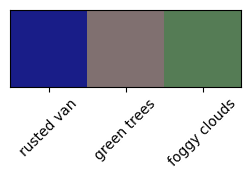

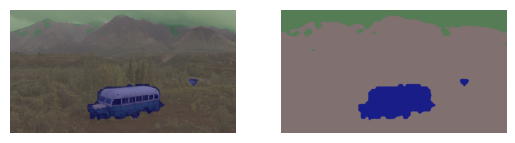

In [27]:
file = 'assets/rusted_van.png'

PALETTE = [[25, 29, 136], [128, 112, 112], [85, 124, 85], [250, 112, 112], [250, 250, 0], [250, 0, 0]]

# specify TEXT PROMPTS
TEXT_PROMPTS = ["rusted van", "green trees", "foggy clouds"] 
SUPPORT_IMAGES = []
model.clip_backbone.decode_head.update_vocab(TEXT_PROMPTS)
model.to(device)

# specify whether applying FOUND or not
model.apply_found = False
mask, ticks, img = visualize_per_image(file, TEXT_PROMPTS, PALETTE, model)

fig, ax = plt.subplots(nrows=1, ncols=2)
alpha=0.5
blend = (alpha)*np.array(img)/255. + (1-alpha)*mask/255.
ax[0].imshow(blend)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
